In [5]:
import pandas as pd
import json
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
import os

/Users/hamza/Code/CS5914/project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
os.getcwd()

'/Users/hamza/Code/CS5914/project/analysis'

# Similarity Score Utils

In [13]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(output, ground):
    # Embed
    emb_ground = model.encode(ground, convert_to_tensor=True)
    emb_completion = model.encode(completion, convert_to_tensor=True)

    # Cosine similarity
    score = util.cos_sim(emb_ground, emb_completion).item()

    return score

In [18]:
def add_similarity_scores(df):
    similarities = []
    
    for idx, row in df.iterrows():
        completion = row['completion']
        ground = row['ground']

        print(completion)
        
        similarity = compute_similarity(completion, ground)
        similarities.append(similarity)

    df['similarity'] = similarities
    return df

# Papers & Masking

## Read Data

In [19]:
PAPERS_CONTEXTLENGTH_FILES = [
    '../completions/masked-papers-completions-temperature-0.5.jsonl'
]

In [20]:
papers_completions = []
for file in PAPERS_CONTEXTLENGTH_FILES:
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            papers_completions.append(json.loads(line))

In [21]:
papers_completions = pd.DataFrame(papers_completions)
papers_completions.head()

,id,title,authors,abstract,published,type,mask_prob,context_length,input,ground,completion,temperature,prompt
0,1709.01507,Squeeze-and-Excitation Networks,"[Jie Hu, Li Shen, Samuel Albanie, Gang Sun, En...",The central building block of convolutional ne...,2017-09-05T17:42:13+00:00,before,0.25,1024,match those sug- gested <MASK> the original <M...,match those sug- gested by the original papers...,match those suggested with the original settin...,0.5,You are a factual information retrieval assist...


## Compute Similarities

In [22]:
papers_completions = add_similarity_scores(papers_completions)

match those suggested with the original settings. We report the performance of each model and its SE counterpart on CIFAR-10 in Table 4 and performance on ImageNet in Table 5. We observe that in every comparison SENets outperform the baseline architectures, suggesting that the benefits of SE blocks are not limited to the ImageNet dataset. 5.2 Scene Classification We also conduct experiments on the Places365 dataset [73] for scene classification. Places365 comprises 8 million training images and 36,500 validation images across 365 categories. Relative to classification, the task of scene understanding offers an alternative assessment of a model’s ability to generalise well and handle diverse data. This is because it often requires the model to handle more complex data associations and to be robust to a high level of appearance variation. We opted to use ResNet-152 as a strong baseline to assess the effectiveness of SE blocks and follow the training and evaluation protocols described in 

NameError: name 'completion' is not defined

## Analysis

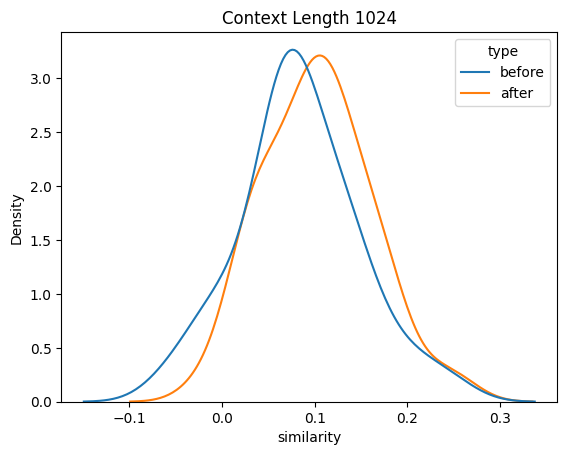

In [68]:
sns.kdeplot(data=papers_completions[papers_completions['context_length'] == 1024], x="similarity", hue='type')
plt.title(f'Context Length {1024}')
plt.show()

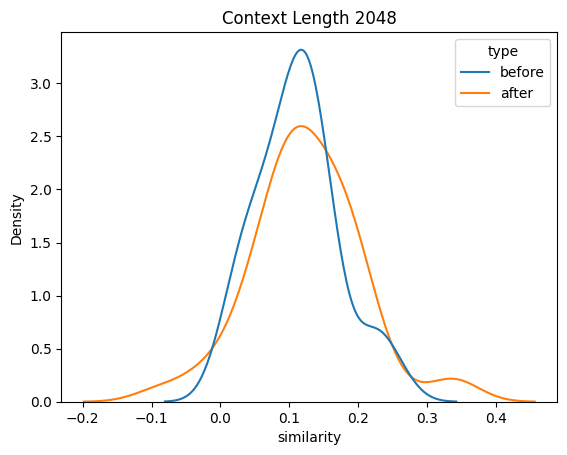

In [69]:
sns.kdeplot(data=papers_completions[papers_completions['context_length'] == 2048], x="similarity", hue='type')
plt.title(f'Context Length {2048}')
plt.show()

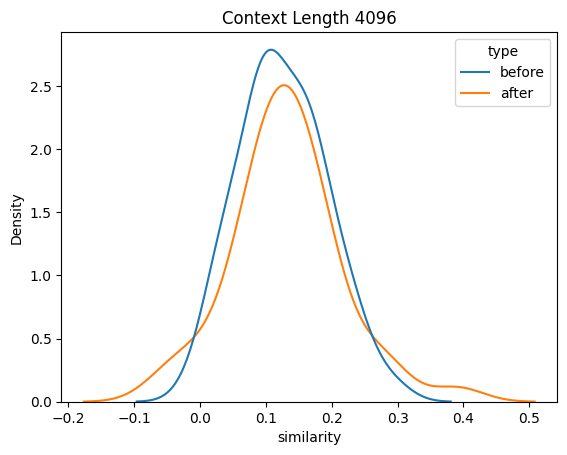

In [70]:
sns.kdeplot(data=papers_completions[papers_completions['context_length'] == 4096], x="similarity", hue='type')
plt.title(f'Context Length {4096}')
plt.show()

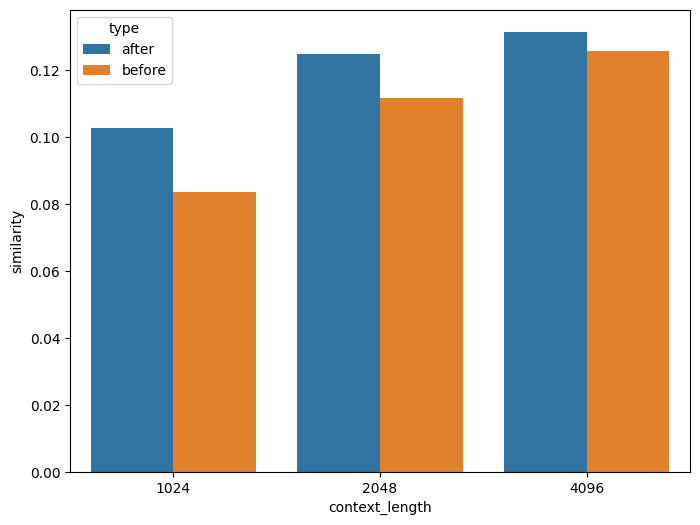

In [71]:
plt.figure(figsize=(8, 6))
x = papers_completions.groupby(['type', 'context_length']).mean('similarity').reset_index()
sns.barplot(x, x='context_length', y='similarity', hue='type')
plt.show()